# NLP with disaster tweets using LSTM (tf)

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import re
import string
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
import numpy as np 
import pandas as pd 
import seaborn as sns
from wordcloud import WordCloud

### The problem
In this project, we will build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. We will have access to a dataset of 10,000 tweets that were hand classified. Eventually, the LSTM model that we  build will help to solve the problem by classifying the tweets in test dataset into disastrous content or not. Natural language processing (NLP) is the ability of a computer program to understand human language as it is spoken and written -- referred to as natural language. It is a component of artificial intelligence (AI). In this project we build LSTM model in supervised deep learning manner to solve the binary classification problem.

### Explore the data folder structure

In [ ]:
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Exploratory Data Analysis
Let's take a look at train dataset and get its data dimention.

In [ ]:
train=pd.read_csv("../input/nlp-getting-started/train.csv")

In [ ]:
train.info()
print(train.target.unique())
print(train.shape)

In [ ]:
train.location.fillna("Unknown", inplace = True)
train.info()

In [ ]:
unique_counts = train['target'].value_counts()
print(unique_counts)

plt.pie(unique_counts.tolist(), 
        labels = ['0-Non-disastrous','1-disastrous'],
        autopct='%1.2f%%'
       )
plt.show()

The train dataset comes with 4 feature columns `id,keyword,location,text` and 1 label colum `target` 7613 rows.
All rows are labelled as either 0 or 1. From above EDA we noticed there are only two distinct values avaible in label column 0 and 1, which represents non-cancerous and canerous respectively. Here we would like to render a pie chart to get a sense on the percentage for these two categories: 0 stands for non-disastrous and 1 stands for disastrous.

In [ ]:
counts, bins = np.histogram(train.target)
plt.stairs(counts, bins)
plt.show()

The histogram proves that target (label) value comes with ether 0 or 1 and there are more 0s than 1s.

In [ ]:
top10locations = train.location.value_counts()[:10]
plt.bar(top10locations.index, top10locations, color ='maroon', width = 0.4)
plt.xlabel("Locations")
plt.xticks(rotation='vertical')
plt.ylabel("Count")
plt.title("Top 10 locations with count")
plt.show()


In [ ]:
train.text[:10]

### Preprocessing with cleansing
As we can find from samples of the text that the tweet content may come with sepecial characters like *#*, *'*, "=>" etc. There is also upper case mixed with lower case words together. We would like to clean up the data by stripping unmeaning characters by having the text processed by the pipelines below. 

When text goes through the cleasing pipeline, unmeaningful text like `https,http`,non-alphabet including sepcial characters, stopwords and punctuation will be removed. (Please find correspond comments below) 

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def lowercase(text):
    return text.lower()

def clean(text):
    t  = re.sub(r"[^a-zA-Z]", " ", text) #Removal of non-alphabet
    t  = t.replace("https"," ") #Removal of https protocal text
    t  = t.replace("http"," ") #Removal of http protocal text
    return t.translate(str.maketrans("","", string.punctuation)) #Removal of punctuation

def tokenize(text):
    t = text.split()
    t = [word for word in t if not word in stop_words]
    return ' '.join(filter(str.isalpha, t)) #Removal of punctuation

preprocessors = [clean, lowercase, tokenize]

for preprocessor in preprocessors:
    train['text']= train['text'].apply(preprocessor)

In [ ]:
train['count_of_words']=[len(x.split()) for x in train['text'].tolist()]

In [ ]:
train.head(10)

In [ ]:
train['count_of_words'].describe()

In [ ]:
from collections import Counter
count = Counter()
def count_word(text):
    for x in text.values:
        for word in x.split():
            count[word]+=1
    return count
counter= count_word(train.text)

Counted total 21977 words from text colum after cleasing

In [ ]:
len(counter)

Here we pick out the top 20 most common words. Longer bar means higher counts.

In [ ]:
most = counter.most_common()
x=[]
y=[]
for word,count in most[:20]:
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

The 20 most common words are also presented below as word cloud diagram.

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join([i[0] for i in most[:20]]))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Train and validation data
We would like split the train data into train and validation datasets based on the 80-20 principal. 
The train data will be used for model to fit. The validation will be used to verify the model's loss and accuracy. To avoid overfit, data will be shuffled before training.

In [ ]:
features, targets= train['text'], train['target']
all_train_features, val_features, all_train_targets, val_targets = train_test_split(
        features, targets,
        train_size=0.8,
        random_state=42,
        shuffle = True,
        stratify=targets
    )

In [ ]:
train_data= tf.data.Dataset.from_tensor_slices((all_train_features.to_numpy(), all_train_targets.to_numpy())) 
val_data= tf.data.Dataset.from_tensor_slices((val_features.to_numpy(),val_targets.to_numpy()))

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

We are not done with the preprocessing yet. A **TextVectorization** layer uses word embedding techniques that represent words mathematically. It transforms a batch of strings into either a list of token indices. Currently `TextVectorization` supports strategies like "int", "multi_hot", "count" or "tf_idf":
- "int": Outputs integer indices, one integer index per split string token. When output_mode == "int", 0 is reserved for masked locations; this reduces the vocab size to max_tokens - 2 instead of max_tokens - 1.
- "multi_hot": Outputs a single int array per batch, of either vocab_size or max_tokens size, containing 1s in all elements where the token mapped to that index exists at least once in the batch item.
- "count": Like "multi_hot", but the int array contains a count of the number of times the token at that index appeared in the batch item.
- "tf_idf": Like "multi_hot", but the TF-IDF algorithm is applied to find the value in each token slot. For "int" output, any shape of input and output is supported. For all other output modes, currently only rank 1 inputs (and rank 2 outputs after splitting) are supported.

Going next, we will call this layer's adapt() method on the dataset. When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a 'vocabulary' from them. 

In [ ]:
vocab_size= 20000
max_len= 15
vectorize_layer = TextVectorization(
    max_tokens=vocab_size + 2,
    split="whitespace",
    output_mode="int",
    output_sequence_length=max_len,
)

In [ ]:
vectorize_layer.adapt(train_data.map(lambda text, label: text))
vectorize_layer.adapt(val_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(vectorize_layer.get_vocabulary())
vocab[:20]

### Model architecture
LSTM will be used for this NLP problem. Lets start with model 1:
the first layer is the Embedded layer that uses vectors to represent each word, which will be followed by bidirectional LSTM layer. The main reason for a bidirectional LSTM is that every component of an input sequence has information from both the past and present. For this reason, bidirectional LSTM can produce a more meaningful output, combining LSTM layers from both directions. The next a few layers will be regular dense layers with relu activation. Dropouts are also enabled to mitigate overfitting problem.
Model architecture is summarized below after model construct and is also plotted to provide finer details. The output layer comes with sigmoid activation to address the binary classification problem. 

In [32]:
vocab_size= 20000
max_len= 15
model1 = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim= vocab_size+1,output_dim=max_len,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh',return_sequences=True)),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
    ])


In [33]:
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [38]:
history1 = model1.fit(train_data, epochs=50,
                    validation_data= val_data)


Epoch 1/50
96/96 [==============================] - 13s 140ms/step - loss: 0.0435 - accuracy: 0.9798 - val_loss: 1.7007 - val_accuracy: 0.7387
Epoch 2/50
96/96 [==============================] - 13s 140ms/step - loss: 0.0378 - accuracy: 0.9813 - val_loss: 1.7810 - val_accuracy: 0.7380
Epoch 3/50
96/96 [==============================] - 14s 142ms/step - loss: 0.0439 - accuracy: 0.9801 - val_loss: 1.5989 - val_accuracy: 0.7341
Epoch 4/50
96/96 [==============================] - 13s 137ms/step - loss: 0.0537 - accuracy: 0.9778 - val_loss: 1.3827 - val_accuracy: 0.7275
Epoch 5/50
96/96 [==============================] - 13s 136ms/step - loss: 0.0490 - accuracy: 0.9780 - val_loss: 1.6013 - val_accuracy: 0.7347
Epoch 6/50
96/96 [==============================] - 13s 137ms/step - loss: 0.0442 - accuracy: 0.9803 - val_loss: 1.6713 - val_accuracy: 0.7367
Epoch 7/50
96/96 [==============================] - 13s 138ms/step - loss: 0.0402 - accuracy: 0.9810 - val_loss: 1.6484 - val_accuracy: 0.7354

### Model performance visualization
With both train and validation datasets, we will plot Accuracy vs Epochs. We expect with epoch's growth, the accuracy shall go up. On the other hand, the loss will go down when epoch grows.

In [48]:
history_dict1 = history1.history
history_dict1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

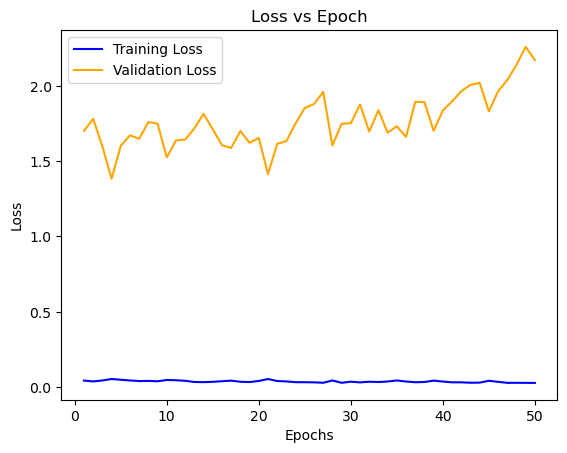

In [49]:
acc1      = history_dict1['accuracy']
val_accuracy1 = history_dict1['val_accuracy']
loss1     = history_dict1['loss']
val_loss1 = history_dict1['val_loss']

epochs1 = range(1, len(acc1) + 1)

plt.plot(epochs1, loss1, 'blue', label='Training Loss')
plt.plot(epochs1, val_loss1, 'orange', label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

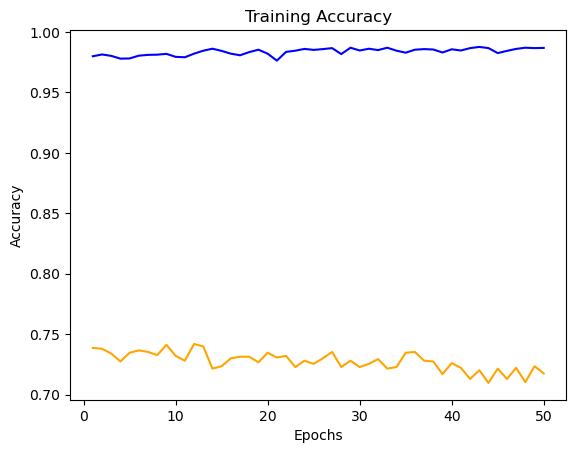

In [50]:
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs1, acc1, 'blue', label='Train Accuracy');
plt.plot(epochs1, val_accuracy1, 'orange', label='Validation Accuracy' )
plt.show()

### Some improvement on the model
We notice that loss of model 1 keeps growing along with epochs and the validation accuracy has the trend to go down when epoch increases as well, which indicates model 1 is to some extend overfitting. We would like to put dropout layers at the end of the repeating structure and lets verify the model performance outcome again.

In [51]:
model2 = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(input_dim= vocab_size+1,output_dim=max_len,mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh',return_sequences=True)),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation='sigmoid')
    ])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [52]:
history2 = model2.fit(train_data, epochs=50,
                    validation_data= val_data)

Epoch 1/50
96/96 [==============================] - 28s 213ms/step - loss: 0.6229 - accuracy: 0.6417 - val_loss: 0.4778 - val_accuracy: 0.7932
Epoch 2/50
96/96 [==============================] - 15s 158ms/step - loss: 0.4214 - accuracy: 0.8217 - val_loss: 0.4421 - val_accuracy: 0.8024
Epoch 3/50
96/96 [==============================] - 15s 157ms/step - loss: 0.3452 - accuracy: 0.8672 - val_loss: 0.4931 - val_accuracy: 0.8030
Epoch 4/50
96/96 [==============================] - 15s 152ms/step - loss: 0.2990 - accuracy: 0.8885 - val_loss: 0.5027 - val_accuracy: 0.7971
Epoch 5/50
96/96 [==============================] - 15s 152ms/step - loss: 0.2625 - accuracy: 0.9041 - val_loss: 0.7662 - val_accuracy: 0.7590
Epoch 6/50
96/96 [==============================] - 14s 151ms/step - loss: 0.2380 - accuracy: 0.9161 - val_loss: 0.6752 - val_accuracy: 0.7846
Epoch 7/50
96/96 [==============================] - 14s 149ms/step - loss: 0.2145 - accuracy: 0.9256 - val_loss: 0.7247 - val_accuracy: 0.7715

In [53]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

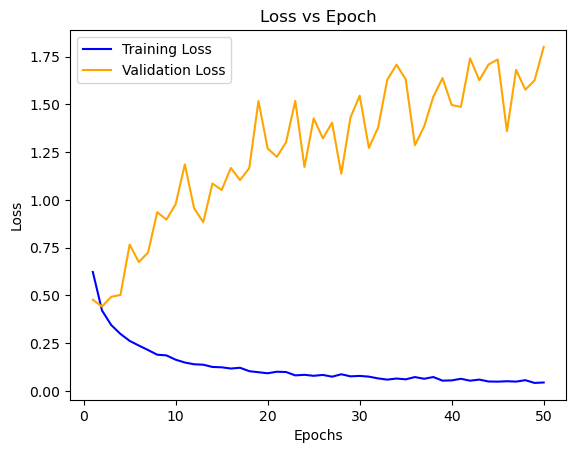

In [54]:
acc2      = history_dict2['accuracy']
val_accuracy2 = history_dict2['val_accuracy']
loss2     = history_dict2['loss']
val_loss2 = history_dict2['val_loss']

epochs2 = range(1, len(acc2) + 1)

plt.plot(epochs2, loss2, 'blue', label='Training Loss')
plt.plot(epochs2, val_loss2, 'orange', label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

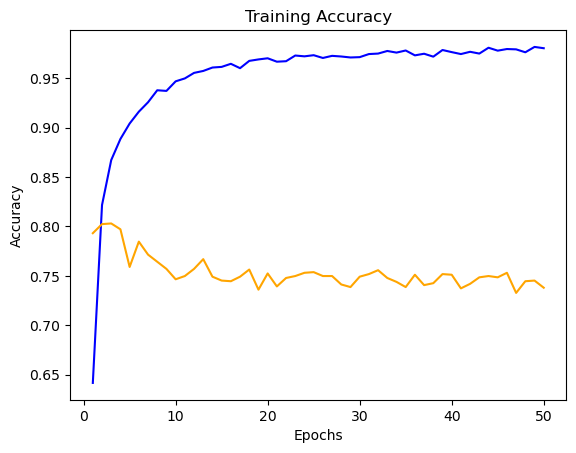

In [55]:
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs2, acc2, 'blue', label='Train Accuracy');
plt.plot(epochs2, val_accuracy2, 'orange', label='Validation Accuracy' )
plt.show()

Comparing to model 1, the training loss of model 2 is lower and the validation loss has the trend of going down. More importantly, the validation accuracy went above 0.75 with growth of epochs which considered as improvement. Verdict is that dropouts worked!

It is very obvious that model 2 has overcome the overfitting issue to some extend, hence it is selected for further prediction.

Lets print out the model summary and plot the the model architecture below:

In [56]:
print(model2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 15, 15)            300015    
                                                                 
 bidirectional_4 (Bidirectio  (None, 15, 128)          40960     
 nal)                                                            
                                                                 
 dense_32 (Dense)            (None, 15, 64)            8256      
                                                                 
 dropout_18 (Dropout)        (None, 15, 64)            0         
                                                                 
 dense_33 (Dense)            (None, 15, 128)          

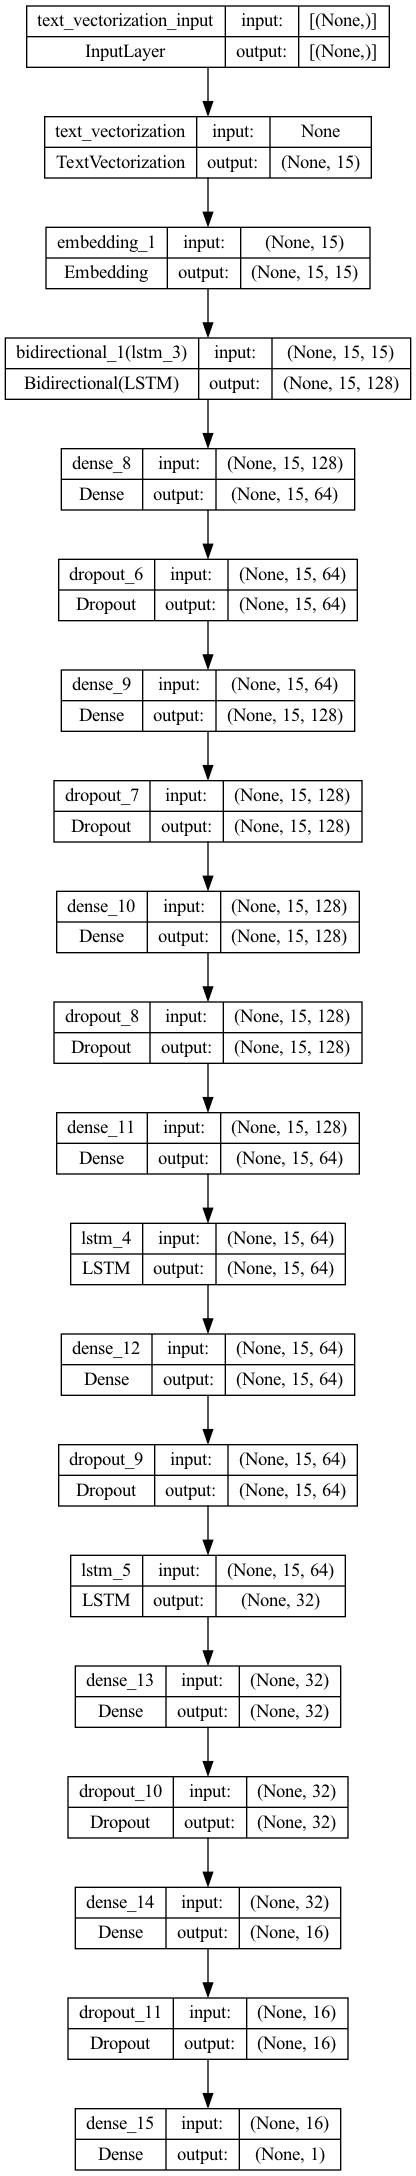

In [57]:
tf.keras.utils.plot_model(model,show_shapes=True)

### Prediction
We will use the trained model to make prediction for submission. The text from test dataset must go through the same preprocessing pipeline as how train data went through.

In [60]:
test=pd.read_csv("../input/nlp-getting-started/test.csv")
for preprocessor in preprocessors:
    test['text']= test['text'].apply(preprocessor)

In [67]:
test_data = test['text']
test_dat_array = test_data.to_numpy()
test_dat_array = tf.data.Dataset.from_tensor_slices((test_dat_array))
test_dat_array = test_dat_array.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
prediction = model2.predict(test_dat_array)

51/51 [==============================] - 8s 84ms/step


In [68]:
prediction_target = []
for pred in prediction:
    if pred >= 0.5:
        prediction_target.append(1)
    else: 
        prediction_target.append(0)

In [69]:
submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [70]:
submission['target'] = prediction_target
submission

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


0    1901
1    1362
Name: target, dtype: int64


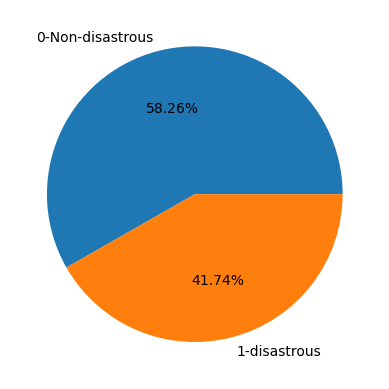

In [71]:
unique_counts = submission['target'].value_counts()
print(unique_counts)

plt.pie(unique_counts.tolist(), 
        labels = ['0-Non-disastrous','1-disastrous'],
        autopct='%1.2f%%'
       )
plt.show()

Above chart depicts that prediction reveals non-disatrous and disastrous are 58.26% and 41.74% respectively.

In [72]:
submission.to_csv("submission.csv",index=False)

### Conclusion
Bidirectional LSTMs can be used to train two sides, instead of one side of the input sequence. First from left to right on the input sequence and the second in reversed order of the input sequence. It provides one more context to the word to fit in the right context from words coming after and before, this results in faster and fully learning and solving a problem. Due to these characteristics, we built a model by fitting it into cleaned tweets text for training and made prediction for test data.

In our first attempt, model was fit into training data very high accuracy however overfitting identified. with dropouts appended to the end of every segment, we observed the traing loss decreased and the validation accuracy improved.

As we analyze the performace by looking at the validation accuracy and loss, there are still room to improve. Tuning up dropout rates may be a direction to look into as the next step to improve the results better.